# Shinkansen Travel Experience

## Hackathon Project by Rahul Rangarajan

This problem statement is based on the Shinkansen Bullet Train in Japan, and passengers’ experience with that mode of travel. This machine-learning exercise aims to determine the relative importance of each parameter with regard to their contribution to the passengers’ overall travel experience. The dataset contains a random sample of individuals who travelled on this train. The on-time performance of the trains along with passenger information is published in a file named ‘Traveldata_train.csv’.  These passengers were later asked to provide their feedback on various parameters related to the travel along with their overall experience. These collected details are made available in the survey report labelled ‘Surveydata_train.csv’.

In the survey, each passenger was explicitly asked whether they were satisfied with their overall travel experience or not, and that is captured in the data of the survey report under the variable labelled ‘Overall_Experience’.

### Objective:
The goal of the problem is to predict whether a passenger was satisfied or not considering his/her overall experience of traveling on the Shinkansen Bullet Train.

### Dataset:
The problem consists of 2 separate datasets: Travel data & Survey data. Travel data has information related to passengers and attributes related to the Shinkansen train, in which they traveled. The survey data is aggregated data of surveys indicating the post-service experience. You are expected to treat both these datasets as raw data and perform any necessary data cleaning/validation steps as required.

The data has been split into two groups and provided in the Dataset folder. The folder contains both train and test data separately.

Target Variable: Overall_Experience (1 represents ‘satisfied’, and 0 represents ‘not satisfied’)

The training set can be used to build your machine-learning model. The training set has labels for the target column - Overall_Experience.

The testing set should be used to see how well your model performs on unseen data. For the test set, it is expected to predict the ‘Overall_Experience’ level for each participant.

## Importing Libraries and Data

In [ ]:
!pip install optuna catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.6 MB/s eta 0:00:00


In [ ]:
#import data manipulation libraries
import numpy as np
import pandas as pd

#import data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score
import catboost

#import deep learning libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

#import hyperparameter tuning libraries
import optuna
from hyperopt import fmin, tpe, hp

#import datasets
from google.colab import drive
drive.mount('/content/drive')
file_path1 = '/content/drive/My Drive/Graduate/MIT_IDSS/Hackathon/Sample_Submission.csv'
file_path2 = '/content/drive/My Drive/Graduate/MIT_IDSS/Hackathon/Surveydata_test.csv'
file_path3 = '/content/drive/My Drive/Graduate/MIT_IDSS/Hackathon/Surveydata_train.csv'
file_path4 = '/content/drive/My Drive/Graduate/MIT_IDSS/Hackathon/Traveldata_test.csv'
file_path5 = '/content/drive/My Drive/Graduate/MIT_IDSS/Hackathon/Traveldata_train.csv'
sample_submission = pd.read_csv(file_path1)
survey_test = pd.read_csv(file_path2)
survey_train = pd.read_csv(file_path3)
travel_test = pd.read_csv(file_path4)
travel_train = pd.read_csv(file_path5)

Mounted at /content/drive


## Data Overview

In [ ]:
print(survey_train.shape)
survey_train.head()

(94379, 17)


,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent
3,98800004,0,Acceptable,Ordinary,Needs Improvement,NaN,Needs Improvement,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable
4,98800005,1,Acceptable,Ordinary,Acceptable,Acceptable,Manageable,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Good,Good


In [ ]:
print(travel_train.shape)
travel_train.head()

(94379, 9)


,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0
3,98800004,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0
4,98800005,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0


In [ ]:
survey_train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,94379.0,9.884719e+07,27245.014865,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Overall_Experience,94379.0,5.466576e-01,0.497821,0.0,0.0,1.0,1.0,1.0


In [ ]:
travel_train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,94379.0,9.884719e+07,27245.014865,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Age,94346.0,3.941965e+01,15.116632,7.0,27.0,40.0,51.0,85.0
Travel_Distance,94379.0,1.978888e+03,1027.961019,50.0,1359.0,1923.0,2538.0,6951.0
Departure_Delay_in_Mins,94322.0,1.464709e+01,38.138781,0.0,0.0,0.0,12.0,1592.0
Arrival_Delay_in_Mins,94022.0,1.500522e+01,38.439409,0.0,0.0,0.0,13.0,1584.0


In [ ]:
survey_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

In [ ]:
travel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


In [ ]:
survey_train.isnull().sum()

,0
ID,0
Overall_Experience,0
Seat_Comfort,61
Seat_Class,0
Arrival_Time_Convenient,8930
Catering,8741
Platform_Location,30
Onboard_Wifi_Service,30
Onboard_Entertainment,18
Online_Support,91


In [ ]:
travel_train.isnull().sum()

,0
ID,0
Gender,77
Customer_Type,8951
Age,33
Type_Travel,9226
Travel_Class,0
Travel_Distance,0
Departure_Delay_in_Mins,57
Arrival_Delay_in_Mins,357


In [ ]:
travel_train.nunique()

,0
ID,94379
Gender,2
Customer_Type,2
Age,75
Type_Travel,2
Travel_Class,2
Travel_Distance,5210
Departure_Delay_in_Mins,437
Arrival_Delay_in_Mins,434


In [ ]:
survey_train.nunique()

,0
ID,94379
Overall_Experience,2
Seat_Comfort,6
Seat_Class,2
Arrival_Time_Convenient,6
Catering,6
Platform_Location,6
Onboard_Wifi_Service,6
Onboard_Entertainment,6
Online_Support,6


## PreProcess

In [ ]:
travel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


In [ ]:
travel_train.drop(['ID'], inplace=True, axis=1)
test_ids = travel_test['ID']
travel_test.drop(['ID'], inplace=True, axis=1)

In [ ]:
#imputing travel datasets: splitting into numerical and categorical
categorical_cols_travel = travel_train.select_dtypes(include=['object']).columns
numerical_cols_travel = travel_train.select_dtypes(include=['float64', 'int64']).columns

In [ ]:
iterative_imputer = IterativeImputer(max_iter=10, random_state=1)
travel_train[numerical_cols_travel] = iterative_imputer.fit_transform(travel_train[numerical_cols_travel])
travel_test[numerical_cols_travel] = iterative_imputer.transform(travel_test[numerical_cols_travel])

In [ ]:
travel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   94302 non-null  object 
 1   Customer_Type            85428 non-null  object 
 2   Age                      94379 non-null  float64
 3   Type_Travel              85153 non-null  object 
 4   Travel_Class             94379 non-null  object 
 5   Travel_Distance          94379 non-null  float64
 6   Departure_Delay_in_Mins  94379 non-null  float64
 7   Arrival_Delay_in_Mins    94379 non-null  float64
dtypes: float64(4), object(4)
memory usage: 5.8+ MB


In [ ]:
#i will use a mode-based imputer to impute categorical columns
mode_imputer = SimpleImputer(strategy='most_frequent')
travel_train[categorical_cols_travel] = mode_imputer.fit_transform(travel_train[categorical_cols_travel])
travel_test[categorical_cols_travel] = mode_imputer.transform(travel_test[categorical_cols_travel])

In [ ]:
travel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   94379 non-null  object 
 1   Customer_Type            94379 non-null  object 
 2   Age                      94379 non-null  float64
 3   Type_Travel              94379 non-null  object 
 4   Travel_Class             94379 non-null  object 
 5   Travel_Distance          94379 non-null  float64
 6   Departure_Delay_in_Mins  94379 non-null  float64
 7   Arrival_Delay_in_Mins    94379 non-null  float64
dtypes: float64(4), object(4)
memory usage: 5.8+ MB


In [ ]:
#encoding categorical data in travel datasets
label_enc_travel = LabelEncoder()
for col in travel_train.select_dtypes(include=['object']).columns:
  travel_train[col] = label_enc_travel.fit_transform(travel_train[col])
  travel_test[col] = label_enc_travel.transform(travel_test[col])

In [ ]:
travel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   94379 non-null  int64  
 1   Customer_Type            94379 non-null  int64  
 2   Age                      94379 non-null  float64
 3   Type_Travel              94379 non-null  int64  
 4   Travel_Class             94379 non-null  int64  
 5   Travel_Distance          94379 non-null  float64
 6   Departure_Delay_in_Mins  94379 non-null  float64
 7   Arrival_Delay_in_Mins    94379 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 5.8 MB


In [ ]:
travel_train.head()

,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,0,1,52.0,0,0,272.0,0.0,5.0
1,1,1,48.0,1,1,2200.0,9.0,0.0
2,0,1,43.0,0,0,1061.0,77.0,119.0
3,0,1,44.0,0,0,780.0,13.0,18.0
4,0,1,50.0,0,0,1981.0,0.0,0.0


In [ ]:
survey_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

In [ ]:
survey_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       35602 non-null  int64 
 1   Seat_Comfort             35580 non-null  object
 2   Seat_Class               35602 non-null  object
 3   Arrival_Time_Convenient  32277 non-null  object
 4   Catering                 32245 non-null  object
 5   Platform_Location        35590 non-null  object
 6   Onboard_Wifi_Service     35590 non-null  object
 7   Onboard_Entertainment    35594 non-null  object
 8   Online_Support           35576 non-null  object
 9   Ease_of_Online_Booking   35584 non-null  object
 10  Onboard_Service          32730 non-null  object
 11  Legroom                  35577 non-null  object
 12  Baggage_Handling         35562 non-null  object
 13  CheckIn_Service          35580 non-null  object
 14  Cleanliness              35600 non-nul

In [ ]:
surveytrain_Overall_Experience = survey_train['Overall_Experience']
survey_train=survey_train.drop(['Overall_Experience'], axis=1)

In [ ]:
#same for survey datasets
categorical_cols_survey = survey_train.select_dtypes(include=['object']).columns
numerical_cols_survey = survey_train.select_dtypes(include=['float64', 'int64']).columns

survey_train[numerical_cols_survey] = iterative_imputer.fit_transform(survey_train[numerical_cols_survey])
survey_test[numerical_cols_survey] = iterative_imputer.transform(survey_test[numerical_cols_survey])

In [ ]:
survey_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  float64
 1   Seat_Comfort             94318 non-null  object 
 2   Seat_Class               94379 non-null  object 
 3   Arrival_Time_Convenient  85449 non-null  object 
 4   Catering                 85638 non-null  object 
 5   Platform_Location        94349 non-null  object 
 6   Onboard_Wifi_Service     94349 non-null  object 
 7   Onboard_Entertainment    94361 non-null  object 
 8   Online_Support           94288 non-null  object 
 9   Ease_of_Online_Booking   94306 non-null  object 
 10  Onboard_Service          86778 non-null  object 
 11  Legroom                  94289 non-null  object 
 12  Baggage_Handling         94237 non-null  object 
 13  CheckIn_Service          94302 non-null  object 
 14  Cleanliness           

In [ ]:
survey_train[categorical_cols_survey] = mode_imputer.fit_transform(survey_train[categorical_cols_survey])
survey_test[categorical_cols_survey] = mode_imputer.transform(survey_test[categorical_cols_survey])

In [ ]:
survey_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  float64
 1   Seat_Comfort             94379 non-null  object 
 2   Seat_Class               94379 non-null  object 
 3   Arrival_Time_Convenient  94379 non-null  object 
 4   Catering                 94379 non-null  object 
 5   Platform_Location        94379 non-null  object 
 6   Onboard_Wifi_Service     94379 non-null  object 
 7   Onboard_Entertainment    94379 non-null  object 
 8   Online_Support           94379 non-null  object 
 9   Ease_of_Online_Booking   94379 non-null  object 
 10  Onboard_Service          94379 non-null  object 
 11  Legroom                  94379 non-null  object 
 12  Baggage_Handling         94379 non-null  object 
 13  CheckIn_Service          94379 non-null  object 
 14  Cleanliness           

In [ ]:
label_enc = LabelEncoder()
for col in survey_train.select_dtypes(include=['object']).columns:
    survey_train[col] = label_enc.fit_transform(survey_train[col])
    survey_test[col] = label_enc.transform(survey_test[col])

In [ ]:
survey_train['Overall_Experience'] = surveytrain_Overall_Experience

In [ ]:
survey_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  float64
 1   Seat_Comfort             94379 non-null  int64  
 2   Seat_Class               94379 non-null  int64  
 3   Arrival_Time_Convenient  94379 non-null  int64  
 4   Catering                 94379 non-null  int64  
 5   Platform_Location        94379 non-null  int64  
 6   Onboard_Wifi_Service     94379 non-null  int64  
 7   Onboard_Entertainment    94379 non-null  int64  
 8   Online_Support           94379 non-null  int64  
 9   Ease_of_Online_Booking   94379 non-null  int64  
 10  Onboard_Service          94379 non-null  int64  
 11  Legroom                  94379 non-null  int64  
 12  Baggage_Handling         94379 non-null  int64  
 13  CheckIn_Service          94379 non-null  int64  
 14  Cleanliness           

In [ ]:
survey_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       35602 non-null  float64
 1   Seat_Comfort             35602 non-null  int64  
 2   Seat_Class               35602 non-null  int64  
 3   Arrival_Time_Convenient  35602 non-null  int64  
 4   Catering                 35602 non-null  int64  
 5   Platform_Location        35602 non-null  int64  
 6   Onboard_Wifi_Service     35602 non-null  int64  
 7   Onboard_Entertainment    35602 non-null  int64  
 8   Online_Support           35602 non-null  int64  
 9   Ease_of_Online_Booking   35602 non-null  int64  
 10  Onboard_Service          35602 non-null  int64  
 11  Legroom                  35602 non-null  int64  
 12  Baggage_Handling         35602 non-null  int64  
 13  CheckIn_Service          35602 non-null  int64  
 14  Cleanliness           

In [ ]:
survey_train.describe()

,ID,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Overall_Experience
count,9.437900e+04,94379.000000,94379.000000,94379.000000,94379.000000,94379.00000,94379.000000,94379.000000,94379.000000,94379.000000,94379.000000,94379.000000,94379.000000,94379.000000,94379.000000,94379.000000,94379.000000
mean,9.884719e+07,2.557677,0.497399,2.545905,2.292713,1.84665,2.350459,2.291113,2.300130,2.314901,2.281419,2.288157,1.573528,2.118448,2.116477,2.203742,0.546658
std,2.724501e+04,1.811015,0.499996,1.666020,1.866532,1.36424,1.746162,1.620448,1.633538,1.646178,1.612809,1.619371,1.092864,1.762610,1.526510,1.745376,0.497821
min,9.880000e+07,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.882360e+07,1.000000,0.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
50%,9.884719e+07,3.000000,0.000000,3.000000,3.000000,2.00000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,1.000000
75%,9.887078e+07,4.000000,1.000000,4.000000,4.000000,3.00000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,2.000000,3.000000,3.000000,4.000000,1.000000
max,9.889438e+07,5.000000,1.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,1.000000


In [ ]:
travel_train.describe()

,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
count,94379.000000,94379.000000,94379.000000,94379.000000,94379.000000,94379.000000,94379.000000,94379.000000
mean,0.492557,0.834656,39.419719,0.281164,0.522807,1978.888185,14.647180,15.077376
std,0.499947,0.371493,15.114187,0.449570,0.499482,1027.961019,38.127266,38.573852
min,0.000000,0.000000,7.000000,0.000000,0.000000,50.000000,0.000000,0.000000
25%,0.000000,1.000000,27.000000,0.000000,0.000000,1359.000000,0.000000,0.000000
50%,0.000000,1.000000,40.000000,0.000000,1.000000,1923.000000,0.000000,0.000000
75%,1.000000,1.000000,51.000000,1.000000,1.000000,2538.000000,12.000000,13.000000
max,1.000000,1.000000,85.000000,1.000000,1.000000,6951.000000,1592.000000,1584.000000


In [ ]:
survey_train.nunique()

,0
ID,94379
Seat_Comfort,6
Seat_Class,2
Arrival_Time_Convenient,6
Catering,6
Platform_Location,6
Onboard_Wifi_Service,6
Onboard_Entertainment,6
Online_Support,6
Ease_of_Online_Booking,6


In [ ]:
travel_train.nunique()

,0
Gender,2
Customer_Type,2
Age,108
Type_Travel,2
Travel_Class,2
Travel_Distance,5210
Departure_Delay_in_Mins,494
Arrival_Delay_in_Mins,791


In [ ]:
survey_train.drop(['ID'], axis=1, inplace=True)

In [ ]:
survey_test.drop(['ID'], axis=1, inplace=True)

In [ ]:
train_df = pd.concat([travel_train, survey_train], axis=1)
train_df.shape

(94379, 24)

In [ ]:
test_df = pd.concat([travel_test, survey_test], axis=1)
test_df.shape

(35602, 23)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   94379 non-null  int64  
 1   Customer_Type            94379 non-null  int64  
 2   Age                      94379 non-null  float64
 3   Type_Travel              94379 non-null  int64  
 4   Travel_Class             94379 non-null  int64  
 5   Travel_Distance          94379 non-null  float64
 6   Departure_Delay_in_Mins  94379 non-null  float64
 7   Arrival_Delay_in_Mins    94379 non-null  float64
 8   Seat_Comfort             94379 non-null  int64  
 9   Seat_Class               94379 non-null  int64  
 10  Arrival_Time_Convenient  94379 non-null  int64  
 11  Catering                 94379 non-null  int64  
 12  Platform_Location        94379 non-null  int64  
 13  Onboard_Wifi_Service     94379 non-null  int64  
 14  Onboard_Entertainment 

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   35602 non-null  int64  
 1   Customer_Type            35602 non-null  int64  
 2   Age                      35602 non-null  float64
 3   Type_Travel              35602 non-null  int64  
 4   Travel_Class             35602 non-null  int64  
 5   Travel_Distance          35602 non-null  float64
 6   Departure_Delay_in_Mins  35602 non-null  float64
 7   Arrival_Delay_in_Mins    35602 non-null  float64
 8   Seat_Comfort             35602 non-null  int64  
 9   Seat_Class               35602 non-null  int64  
 10  Arrival_Time_Convenient  35602 non-null  int64  
 11  Catering                 35602 non-null  int64  
 12  Platform_Location        35602 non-null  int64  
 13  Onboard_Wifi_Service     35602 non-null  int64  
 14  Onboard_Entertainment 

### Removal of outliers:

In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,94379.0,0.492557,0.499947,0.0,0.0,0.0,1.0,1.0
Customer_Type,94379.0,0.834656,0.371493,0.0,1.0,1.0,1.0,1.0
Age,94379.0,39.419719,15.114187,7.0,27.0,40.0,51.0,85.0
Type_Travel,94379.0,0.281164,0.449570,0.0,0.0,0.0,1.0,1.0
Travel_Class,94379.0,0.522807,0.499482,0.0,0.0,1.0,1.0,1.0
Travel_Distance,94379.0,1978.888185,1027.961019,50.0,1359.0,1923.0,2538.0,6951.0
Departure_Delay_in_Mins,94379.0,14.647180,38.127266,0.0,0.0,0.0,12.0,1592.0
Arrival_Delay_in_Mins,94379.0,15.077376,38.573852,0.0,0.0,0.0,13.0,1584.0
Seat_Comfort,94379.0,2.557677,1.811015,0.0,1.0,3.0,4.0,5.0
Seat_Class,94379.0,0.497399,0.499996,0.0,0.0,0.0,1.0,1.0


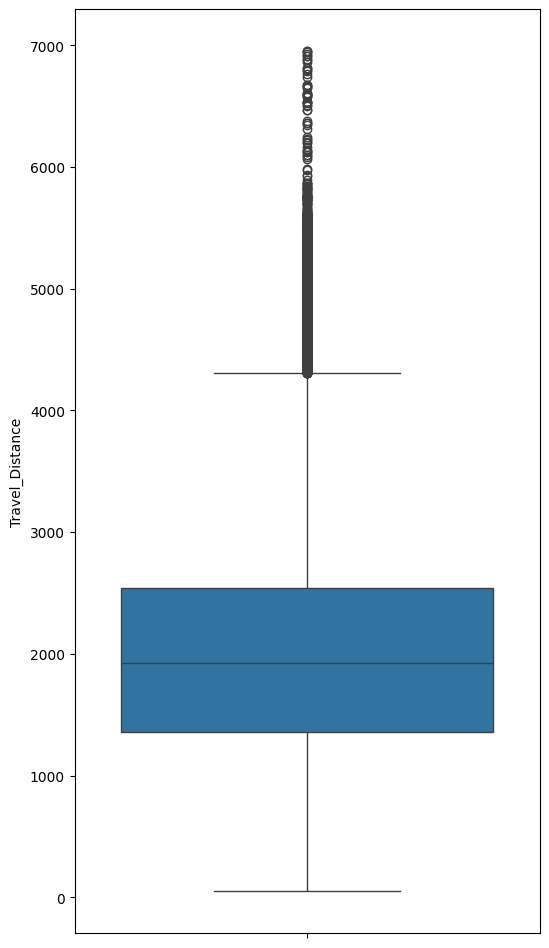

In [ ]:
boxplot_distance = plt.figure(figsize=(6,12))
boxplot_distance = sns.boxplot(train_df['Travel_Distance'])

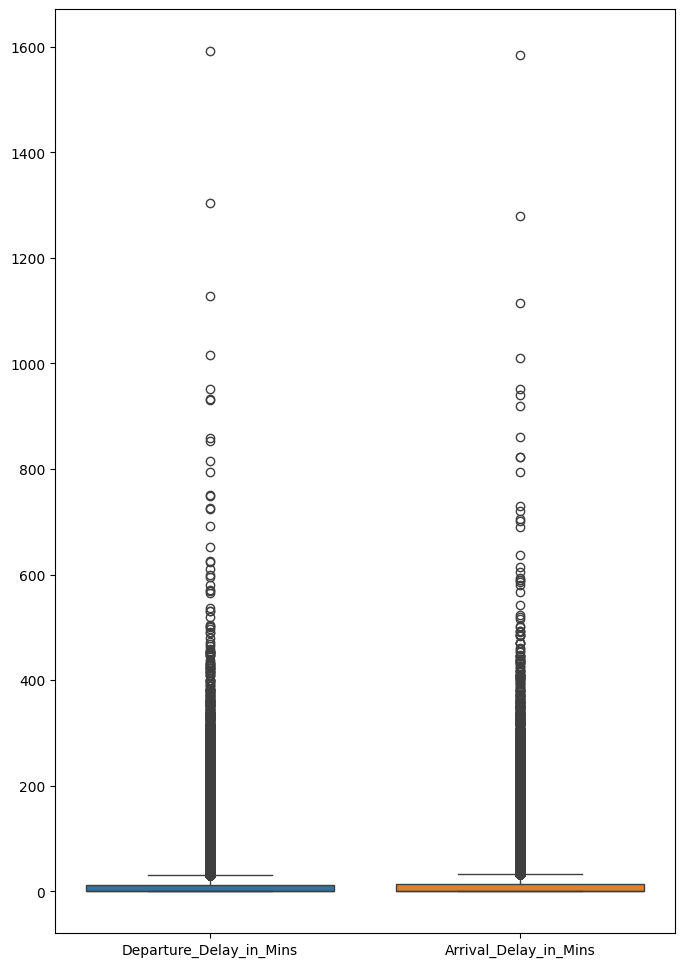

In [ ]:
minutes_columns = ['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']
boxplot_minutes = plt.figure(figsize=(8,12))
boxplot_minutes = sns.boxplot(train_df[minutes_columns])

Based on these plots, it can be seen that these three features contain a large amount of outliers. However, the bigger outlier issues lie in the delays as the outliers are so much further beyond the range of most values. we might take a multi step approach to address these three features.
* Travel_Distance: We can cap outliers for this by creating an upper bound. While high values indicate valid, long journeys, it might hurt the model if left unbounded
* Departure_Delay_in_Mins and Arrival_Delay_in_Mins: These features will benefit from removing extreme outliers and then log transforming moderate outliers to reduce noise altogether.

In [ ]:
travel_distance_upper_bound = 4306.5
departure_delay_upper_bound = 60
arrival_delay_upper_bound = 60

In [ ]:
def handle_outliers(df):
  # Cap Travel_Distance
  df['Travel_Distance'] = df['Travel_Distance'].clip(upper=travel_distance_upper_bound)

  # Cap and log-transform Departure_Delay_in_Mins
  df['Departure_Delay_in_Mins'] = df['Departure_Delay_in_Mins'].clip(upper=departure_delay_upper_bound)
  df['Departure_Delay_in_Mins'] = np.log1p(df['Departure_Delay_in_Mins'])

  # Cap and log-transform Arrival_Delay_in_Mins
  df['Arrival_Delay_in_Mins'] = df['Arrival_Delay_in_Mins'].clip(upper=arrival_delay_upper_bound)
  df['Arrival_Delay_in_Mins'] = np.log1p(df['Arrival_Delay_in_Mins'])

  return df

In [ ]:
train_df = handle_outliers(train_df)
test_df = handle_outliers(test_df)

In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,94379.0,0.492557,0.499947,0.0,0.0,0.0,1.000000,1.000000
Customer_Type,94379.0,0.834656,0.371493,0.0,1.0,1.0,1.000000,1.000000
Age,94379.0,39.419719,15.114187,7.0,27.0,40.0,51.000000,85.000000
Type_Travel,94379.0,0.281164,0.449570,0.0,0.0,0.0,1.000000,1.000000
Travel_Class,94379.0,0.522807,0.499482,0.0,0.0,1.0,1.000000,1.000000
Travel_Distance,94379.0,1966.796782,994.292297,50.0,1359.0,1923.0,2538.000000,4306.500000
Departure_Delay_in_Mins,94379.0,1.190342,1.529650,0.0,0.0,0.0,2.564949,4.110874
Arrival_Delay_in_Mins,94379.0,1.222397,1.541826,0.0,0.0,0.0,2.639057,4.110874
Seat_Comfort,94379.0,2.557677,1.811015,0.0,1.0,3.0,4.000000,5.000000
Seat_Class,94379.0,0.497399,0.499996,0.0,0.0,0.0,1.000000,1.000000


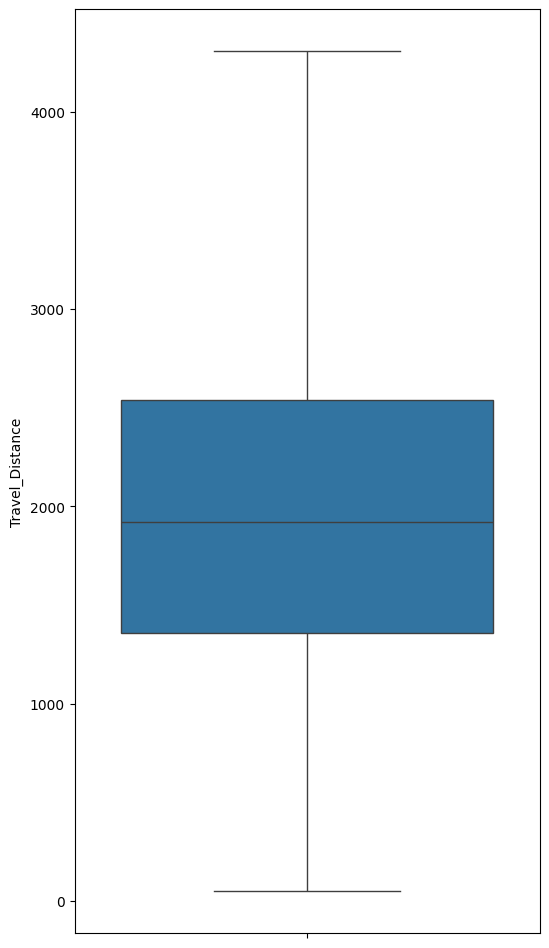

In [ ]:
boxplot_distance = plt.figure(figsize=(6,12))
boxplot_distance = sns.boxplot(train_df['Travel_Distance'])

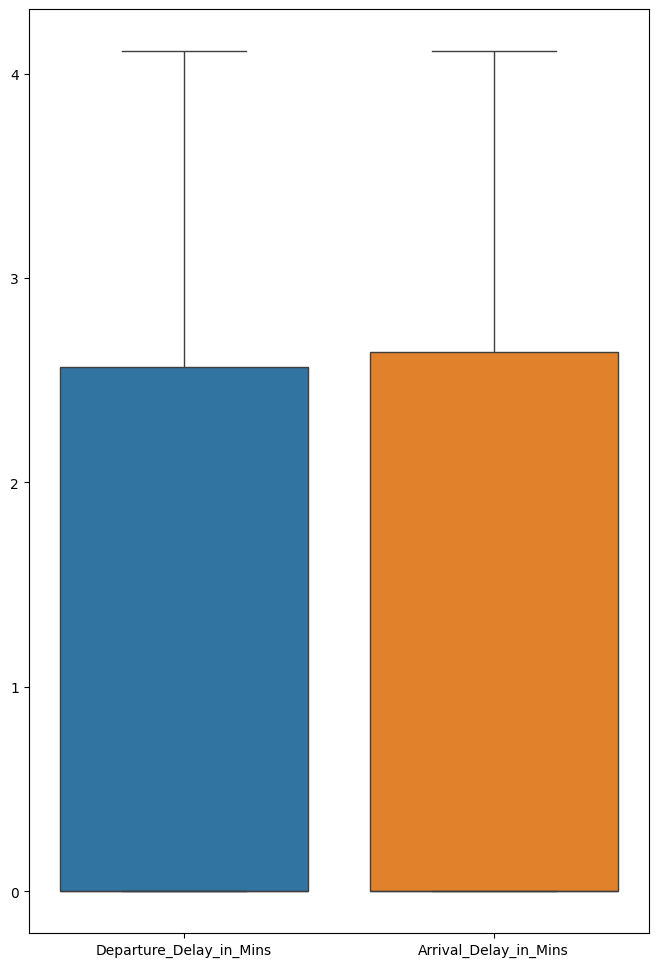

In [ ]:
minutes_columns = ['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']
boxplot_minutes = plt.figure(figsize=(8,12))
boxplot_minutes = sns.boxplot(train_df[minutes_columns])

### Scaling:

In [ ]:
scale_cols = [
    'Travel_Distance',
    'Age',
    'Departure_Delay_in_Mins',
    'Arrival_Delay_in_Mins'
]

In [ ]:
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

In [ ]:
train_df[['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']] = \
    robust_scaler.fit_transform(train_df[['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']])

test_df[['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']] = \
    robust_scaler.transform(test_df[['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']])

In [ ]:
train_df['Travel_Distance'] = robust_scaler.fit_transform(train_df[['Travel_Distance']])
test_df['Travel_Distance'] = robust_scaler.transform(test_df[['Travel_Distance']])

In [ ]:
train_df['Age'] = standard_scaler.fit_transform(train_df[['Age']])
test_df['Age'] = standard_scaler.transform(test_df[['Age']])

In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,94379.0,4.925566e-01,0.499947,0.000000,0.000000,0.000000,1.000000,1.000000
Customer_Type,94379.0,8.346560e-01,0.371493,0.000000,1.000000,1.000000,1.000000,1.000000
Age,94379.0,4.777656e-16,1.000005,-2.144997,-0.821730,0.038393,0.766190,3.015744
Type_Travel,94379.0,2.811642e-01,0.449570,0.000000,0.000000,0.000000,1.000000,1.000000
Travel_Class,94379.0,5.228070e-01,0.499482,0.000000,0.000000,1.000000,1.000000,1.000000
Travel_Distance,94379.0,3.714740e-02,0.843335,-1.588634,-0.478372,0.000000,0.521628,2.021628
Departure_Delay_in_Mins,94379.0,4.640799e-01,0.596366,0.000000,0.000000,0.000000,1.000000,1.602712
Arrival_Delay_in_Mins,94379.0,4.631945e-01,0.584234,0.000000,0.000000,0.000000,1.000000,1.557705
Seat_Comfort,94379.0,2.557677e+00,1.811015,0.000000,1.000000,3.000000,4.000000,5.000000
Seat_Class,94379.0,4.973988e-01,0.499996,0.000000,0.000000,0.000000,1.000000,1.000000


In [ ]:
target = 'Overall_Experience'
X_train = train_df.drop(columns=[target])
y_train = train_df[target]

## Modelling!

We will construct an ensemble of random forest classifier, catboost, and neural networks

1. RandomForestClassifier (With optuna)

In [ ]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 400,450)
  max_depth = trial.suggest_int('max_depth', 40,45)
  min_samples_split = trial.suggest_int('min_samples_split', 2,3)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1,2)

  model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=1
  )
  score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score)).mean()
  return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
best_params = study.best_params

[I 2024-12-08 19:46:08,891] A new study created in memory with name: no-name-327a9534-3cf7-48b8-be13-0f7834b93ae7
[I 2024-12-08 19:50:56,921] Trial 0 finished with value: 0.9514797959569963 and parameters: {'n_estimators': 447, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9514797959569963.
[I 2024-12-08 19:55:31,980] Trial 1 finished with value: 0.9502599316296243 and parameters: {'n_estimators': 443, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9514797959569963.
[I 2024-12-08 19:59:51,715] Trial 2 finished with value: 0.951527800066866 and parameters: {'n_estimators': 406, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.951527800066866.
[I 2024-12-08 20:04:35,281] Trial 3 finished with value: 0.9515165209400844 and parameters: {'n_estimators': 442, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 2 with value: 


[I 2024-12-08 21:15:28,674] Trial 19 finished with value: 0.951783674706523 and parameters: {'n_estimators': 449, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 19 with value: 0.951783674706523.

In [ ]:
final_rf_model = RandomForestClassifier(**best_params, random_state=1)
final_rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=43, min_samples_split=3, n_estimators=449,
                       random_state=1)

In [ ]:
rf_predictions = final_rf_model.predict(test_df)

In [ ]:
submission_rfc = pd.DataFrame({'ID': test_ids, 'Overall_Experience': rf_predictions})
submission_rfc.to_csv('submission_rfc.csv', index=False)
print("RFC Submission file saved!")

RFC Submission file saved!


2. CatBoost (with HyperOpt)

In [ ]:
def objective(params):
    model = catboost.CatBoostClassifier(
        iterations=params['iterations'],
        depth=params['depth'],
        learning_rate=params['learning_rate'],
        l2_leaf_reg=params['l2_leaf_reg'],
        verbose=0
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    return -score

In [ ]:
space = {
    'iterations': hp.choice('iterations', range(100, 1000)),
    'depth': hp.choice('depth', range(3, 12)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -3, 3),
}

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)
best_model = catboost.CatBoostClassifier(**best, verbose=0)
best_model.fit(X_train, y_train)

100%|██████████| 50/50 [1:17:38<00:00, 93.17s/trial, best loss: -0.9584239002252268]


100%|██████████| 50/50 [1:47:55<00:00, 129.51s/trial, best loss: -0.9588758677134652]
<catboost.core.CatBoostClassifier at 0x7e7386731360>

In [ ]:
catboost_predictions = best_model.predict(test_df)

In [ ]:
submission_cb = pd.DataFrame({'ID': test_ids, 'Overall_Experience': catboost_predictions})
submission_cb.to_csv('submission_cb.csv', index=False)
print("CatBoost Submission file saved!")

CatBoost Submission file saved!


3. Neural Network (with Adam)

In [ ]:
early_stopping = EarlyStopping(
    patience=20,
    restore_best_weights=True
)

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6972 - loss: 0.5638 - val_accuracy: 0.8737 - val_loss: 0.3061
Epoch 2/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8577 - loss: 0.3376 - val_accuracy: 0.8985 - val_loss: 0.2479
Epoch 3/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8803 - loss: 0.2879 - val_accuracy: 0.9063 - val_loss: 0.2274
Epoch 4/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8921 - loss: 0.2613 - val_accuracy: 0.9121 - val_loss: 0.2126
Epoch 5/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8991 - loss: 0.2449 - val_accuracy: 0.9166 - val_loss: 0.2030
Epoch 6/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9042 - loss: 0.2351 - val_accuracy: 0.9174 - val_loss: 0.1958
Epoch 7/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9060 - loss: 0.2274 - val_accuracy: 0.9161 - val_loss: 0.1906
Epoch 8/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9069 - loss: 

In [ ]:
nn_predictions = (model.predict(test_df) > 0.5).astype(int).flatten()

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from keras_tuner.tuners import RandomSearch

In [ ]:
def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Dense(
        units=hp.Int('units_input', min_value=32, max_value=128, step=32),
        activation='relu',
        input_dim=X_train.shape[1]
    ))

    # Hidden layers
    for i in range(hp.Int('num_hidden_layers', 1, 3)):  # Choose 1-3 hidden layers
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=16, max_value=64, step=16),
            activation='relu'
        ))
        model.add(Dropout(rate=hp.Choice(f'dropout_{i}', values=[0.2, 0.3, 0.4])))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with hyperparameters
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='adam_hyperparameter_tuning'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    batch_size=32
)

Trial 10 Complete [00h 07m 02s]
val_accuracy: 0.9342551231384277

Best val_accuracy So Far: 0.9413011074066162
Total elapsed time: 01h 03m 03s


In [83]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
Input units: {best_hps.get('units_input')}
Number of hidden layers: {best_hps.get('num_hidden_layers')}
Learning rate: {best_hps.get('learning_rate')}
Dropout rates: {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('num_hidden_layers'))]}
""")


Best Hyperparameters:
Input units: 96
Number of hidden layers: 1
Learning rate: 0.001
Dropout rates: [0.4]



Best Hyperparameters:
Input units: 64
Number of hidden layers: 3
Learning rate: 0.001
Dropout rates: [0.3, 0.3, 0.3]

In [84]:
best_model_dl = tuner.hypermodel.build(best_hps)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [85]:
history = best_model_dl.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.7913 - loss: 0.4397 - val_accuracy: 0.8962 - val_loss: 0.2469
Epoch 2/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.8962 - loss: 0.2454 - val_accuracy: 0.9115 - val_loss: 0.2076
Epoch 3/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9110 - loss: 0.2101 - val_accuracy: 0.9148 - val_loss: 0.1969
Epoch 4/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9166 - loss: 0.1942 - val_accuracy: 0.9180 - val_loss: 0.1839
Epoch 5/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9207 - loss: 0.1839 - val_accuracy: 0.9241 - val_loss: 0.1786
Epoch 6/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9254 - loss: 0.1730 - val_accuracy: 0.9228 - val_loss: 0.1785
Epoch 7/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9269 - loss: 0.1700 - val_accuracy: 0.9262 - val_loss: 0.1684
Epoch 8/100
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9317 - los

In [86]:
history_df = pd.DataFrame(history.history)

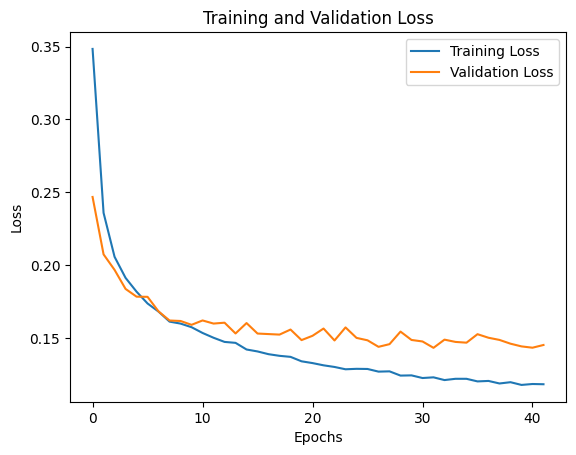

In [87]:
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

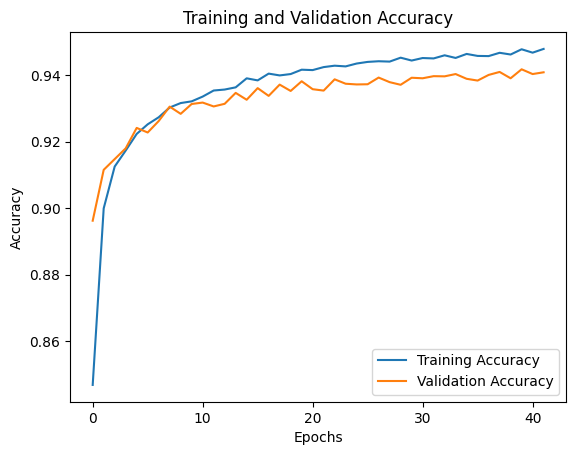

In [88]:
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [90]:
dl_predictions = best_model_dl.predict(test_df)
dl_predictions = (dl_predictions > 0.5).astype(int)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [94]:
dl_predictions = dl_predictions.T

### Additional Models

In [112]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [97]:
# Initialize models
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)
lgbm_model = LGBMClassifier(random_state=1)

In [98]:
# Train models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:20:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 51593, number of negative: 42786
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 94379, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546658 -> initscore=0.187175
[LightGBM] [Info] Start training from score 0.187175


LGBMClassifier(random_state=1)

In [99]:
xgb_param_grid = {
    'n_estimators': [300,350,400],
    'max_depth': [7,8,9],
    'learning_rate': [0.1],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}

In [100]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)

In [101]:
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters for XGBoost:", xgb_grid_search.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:22:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 350, 'subsample': 1.0}


Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 350, 'subsample': 1.0}

In [102]:
best_xgb_model = xgb_grid_search.best_estimator_

In [103]:
lgbm_param_grid = {
    'n_estimators': [300,350,400],
    'max_depth': [-1, 5],
    'learning_rate': [0.1],
    'num_leaves': [100,125],
    'subsample': [0.7,0.8,0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [104]:
lgbm_model = LGBMClassifier(random_state=1)

In [106]:
lgbm_grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
lgbm_grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters for LightGBM:", lgbm_grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 51593, number of negative: 42786
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 94379, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546658 -> initscore=0.187175
[LightGBM] [Info] Start training from score 0.187175
Best Parameters for LightGBM: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 350, 'num_leaves': 125, 'subsample': 0.7}


Best Parameters for LightGBM: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 350, 'num_leaves': 125, 'subsample': 0.7}

In [107]:
best_lgbm_model = lgbm_grid_search.best_estimator_

### Ensembling:

In [120]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [109]:
dl_predictions = best_model_dl.predict(test_df)
dl_predictions = dl_predictions.flatten()
rf_predictions = final_rf_model.predict_proba(test_df)[:, 1]
cb_predictions = best_model.predict_proba(test_df)[:, 1]
xgb_predictions = best_xgb_model.predict_proba(test_df)[:, 1]
lgbm_predictions = best_lgbm_model.predict_proba(test_df)[:, 1]

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [110]:
X_train_stacking, X_val_stacking, y_train_stacking, y_val_stacking = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [116]:
dl_val_predictions = best_model_dl.predict(X_val_stacking)
dl_val_predictions = dl_val_predictions.flatten()

rf_val_predictions = final_rf_model.predict_proba(X_val_stacking)[:, 1]

cb_val_predictions = best_model.predict_proba(X_val_stacking)[:, 1]

xgb_val_predictions = best_xgb_model.predict_proba(X_val_stacking)[:, 1]

lgbm_val_predictions = best_lgbm_model.predict_proba(X_val_stacking)[:, 1]

590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [117]:
stacked_val_features = np.column_stack((dl_val_predictions, rf_val_predictions, cb_val_predictions, xgb_val_predictions, lgbm_val_predictions))

In [125]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),  # Updated
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),  # Updated
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
        'verbose': 0  # Suppress training logs
    }

    # Initialize the CatBoostClassifier with the sampled parameters
    model = CatBoostClassifier(**params)

    # Use cross-validation to evaluate the model
    score = cross_val_score(model, X_train_stacking, y_train_stacking,
                            cv=3, scoring=make_scorer(f1_score)).mean()
    return score

In [129]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-12-09 02:34:49,698] A new study created in memory with name: no-name-f0348530-558d-455e-95fd-75ea25ff6cee
[I 2024-12-09 02:39:01,718] Trial 0 finished with value: 0.9462146300317588 and parameters: {'iterations': 871, 'learning_rate': 0.008359899665750825, 'depth': 11, 'l2_leaf_reg': 1.4123237151071943, 'bagging_temperature': 0.8437160886828386, 'random_strength': 9.11665826953794}. Best is trial 0 with value: 0.9462146300317588.
[I 2024-12-09 02:39:59,795] Trial 1 finished with value: 0.9390862236216249 and parameters: {'iterations': 705, 'learning_rate': 0.007253813756637676, 'depth': 8, 'l2_leaf_reg': 4.431096027720446, 'bagging_temperature': 0.9598447005110349, 'random_strength': 5.015119934732636}. Best is trial 0 with value: 0.9462146300317588.
[I 2024-12-09 02:40:53,272] Trial 2 finished with value: 0.9492177793494188 and parameters: {'iterations': 887, 'learning_rate': 0.014927227538222817, 'depth': 6, 'l2_leaf_reg': 4.716205959685962, 'bagging_temperature': 0.845170861

In [131]:
print("Best Hyperparameters:", study.best_trial.params)
print("Best F1 Score:", study.best_trial.value)

Best Hyperparameters: {'iterations': 928, 'learning_rate': 0.03917034348810976, 'depth': 9, 'l2_leaf_reg': 1.075067799935238, 'bagging_temperature': 0.6796730284904646, 'random_strength': 0.7337384096421986}
Best F1 Score: 0.9579031458233734


In [135]:
final_meta_model = CatBoostClassifier(
    iterations=928,
    learning_rate=0.03917034348810976,
    depth=9,
    l2_leaf_reg=1.075067799935238,
    bagging_temperature=0.6796730284904646,
    random_strength=0.7337384096421986,
    eval_metric='F1',
    verbose=100
)

final_meta_model.fit(X_train, y_train)

0:	learn: 0.8956049	total: 44.1ms	remaining: 40.8s
100:	learn: 0.9497816	total: 4.37s	remaining: 35.8s
200:	learn: 0.9599016	total: 8.6s	remaining: 31.1s
300:	learn: 0.9655714	total: 15.6s	remaining: 32.4s
400:	learn: 0.9700585	total: 19.8s	remaining: 26s
500:	learn: 0.9739575	total: 24s	remaining: 20.4s
600:	learn: 0.9770284	total: 30.9s	remaining: 16.8s
700:	learn: 0.9803697	total: 35.3s	remaining: 11.4s
800:	learn: 0.9833220	total: 39.7s	remaining: 6.3s
900:	learn: 0.9856505	total: 46.8s	remaining: 1.4s
927:	learn: 0.9861476	total: 47.9s	remaining: 0us


In [136]:
y_val_pred = final_meta_model.predict(X_val_stacking)

# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix

print("Validation Set Metrics:")
print(classification_report(y_val_stacking, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val_stacking, y_val_pred))

Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8562
           1       0.99      0.98      0.99     10314

    accuracy                           0.99     18876
   macro avg       0.99      0.99      0.99     18876
weighted avg       0.99      0.99      0.99     18876

Confusion Matrix:
[[ 8451   111]
 [  162 10152]]


## Submission:

In [137]:
# Predict on test set
stacking_test_predictions = final_meta_model.predict(test_df)

# Save predictions
submission = pd.DataFrame({'ID': test_ids, 'Overall_Experience': stacking_test_predictions})
submission.to_csv('final_submission.csv', index=False)
print("Submission file saved as 'final_submission.csv'")

Submission file saved as 'final_submission.csv'


## Observation:

In [138]:
feature_importances = final_meta_model.get_feature_importance(prettified=True)
print("Feature Importances:")
print(feature_importances)

Feature Importances:
                 Feature Id  Importances
0              Seat_Comfort    24.047785
1     Onboard_Entertainment     8.377878
2               Type_Travel     6.649909
3         Platform_Location     6.338081
4                    Gender     4.949358
5    Ease_of_Online_Booking     4.734548
6             Customer_Type     4.665376
7              Travel_Class     4.341094
8                       Age     4.288080
9   Arrival_Time_Convenient     3.796759
10              Cleanliness     3.389214
11         Baggage_Handling     3.169789
12           Online_Support     3.142173
13          Travel_Distance     3.023019
14          CheckIn_Service     2.889217
15                  Legroom     2.434044
16          Online_Boarding     2.168372
17                 Catering     2.062131
18          Onboard_Service     2.031349
19    Arrival_Delay_in_Mins     1.285833
20     Onboard_Wifi_Service     1.032179
21  Departure_Delay_in_Mins     0.791230
22               Seat_Class     0.39

In [139]:
from sklearn.metrics import roc_curve, auc, PrecisionRecallDisplay

# Compute probabilities and ROC curve
y_val_prob = final_meta_model.predict_proba(X_val_stacking)[:, 1]
fpr, tpr, _ = roc_curve(y_val_stacking, y_val_prob)
roc_auc = auc(fpr, tpr)

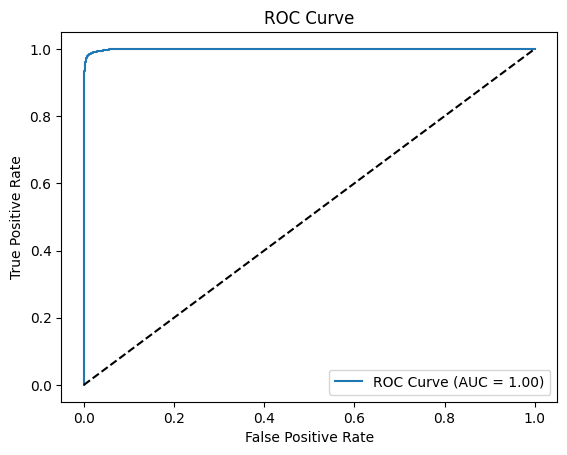

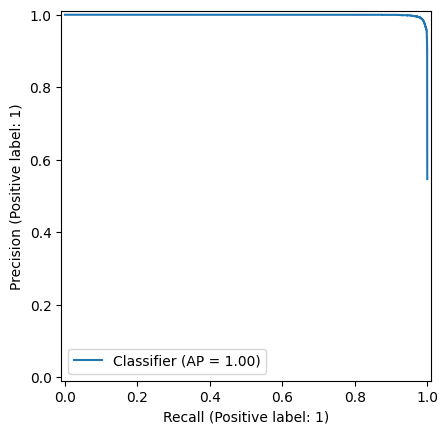

In [140]:
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_val_stacking, y_val_prob)
plt.show()